# World Health Organization Mental Health Resources Study

Dr. Pablo Salcado &
Dr. Kelly Epley

This notebook documents the code we used to conduct our analysis of the 2016 WHO suicide data and data on global mental health resources and suicide rates (ages 15-29) per country per 100,000 population.

In this study, we treat suicide rates as a proxy for the effectiveness of available mental health resources. We want to emphasize that it is an imperfect proxy, but one that is easily quantifiable and representative of clear failures of intervention. See the accompanying readme for a detailed explanation of our rationale for the study and our background research.

## Packages used in our analysis

In [1]:
import pandas as pd
import numpy as np
import sqlite3
from statistics import mean, stdev
from math import sqrt
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from bootstrap_and_compare_function import *
from get_data import *

## The data

Custom functions containing the SQL queries we used to extract data from the database who_suicides can be found in a .py file named "get data."

We created two groups of countries in the human_resources table according to their number of mental health providers and joined the results with the suicide_rate table. Note that the number of mental health providers is a sum of the psychiatrist, psychologist, dedicated mental health nurse, and social worker columns. Each provider is given equal weight in our analysis regardless of provider type.

We also created groups according to gender so we could analyse the suicide rates for males and females in countries with high or low available mental health providers.

In [45]:
df_with_nulls = get_data()
df_suicide_rate_btsx_above = get_btsx_above()
df_suicide_rate_btsx_below = get_btsx_below()
df_suicide_rate_male_above = get_male_above()
df_suicide_rate_male_below = get_male_below()
df_suicide_rate_female_above = get_female_above()
df_suicide_rate_female_below = get_female_below()


### Table Schema

| suicide_rate | 
|------|
|   Country |
|   Year |
|    15-29 years |
|    35-50 years | 
    
| human_resources | 
|------|
|   Country |
|   Year |
|    Psychologists working in mental health sector (per 100 000 population) |
|    Nurses working in mental health sector (per 100 000 population) |
|    Social workers working in mental health sector (per 100 000 population) |
|    Psychiatrists working in mental health sector (per 100 000 population) | 
    
| facilities | 
|------|
|   Country |
|    Year |
|    Mental hospitals (per 100 000 population) |
|    Mental health units in general hospitals (per 100 000 population) |
|    Mental health outpatient facilities (per 100 000 population) |
|   Mental health day treatment facilities (per 100 000 population) |
|    Community residential facilities (per 100 000 population |

# Does availability of mental health providers improve mental health outcomes?

* ### Alternative Hypothesis 1: 
There is a difference in suicide rates for countries below and above the mean threshold of mental health providers per 100,000 people ages 15-29.

* ### Null Hypothesis: 
There is no difference.

As you can see from the image below, the distributions of suicides in countries with above average vs. below average numbers of providers are not normal distributions. 

Also, the above average group of countries is small compared to the below average group.

Hence, we decided to bootstrap samples and create a sampling distribution to compare the populations using a Welch's T Test for two independent samples.



Number of countries in the above mean group: 35
Number of countries in the below mean group: 114


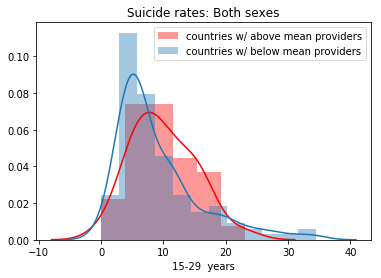

In [46]:
print("Number of countries in the above mean group:", len(df_suicide_rate_btsx_above))
print("Number of countries in the below mean group:", len(df_suicide_rate_btsx_below))

sns.distplot(df_suicide_rate_btsx_above["15-29  years"], color='red', label="countries w/ above mean providers")
sns.distplot(df_suicide_rate_btsx_below["15-29  years"], label="countries w/ below mean providers")
plt.title("Suicide rates: Both sexes")
plt.legend()
plt.savefig("raw_dist_btsx")

* ### T TEST for two independent samples

We generated 1000 samples of 500 (with replacement) from the original samples. The results of the T test were significant, but the effect size is small. Note that, somewhat surprisingly, countries with more mental health resources have more reported suicides for ages 15-29. See the readme for discussion.

With p=0.0, we can reject the Null Hypothesis. These populations are different.


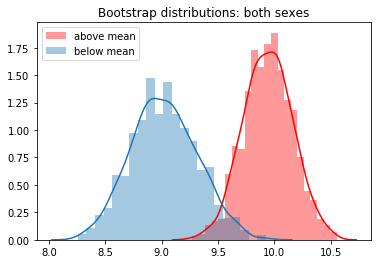

In [47]:
samp1=df_suicide_rate_btsx_above["15-29  years"]
samp2=df_suicide_rate_btsx_below["15-29  years"]
bootstrap_and_compare(samp1, samp2, num_bootstraps=1000, size_bootstraps=500)

plt.title("Bootstrap distributions: both sexes")
plt.savefig("bootstrap_dist_btsx")

In [48]:
effect_size = (mean(samp1) - mean(samp2)) / (sqrt((stdev(samp1) ** 2 + stdev(samp2) ** 2) / 2))

print("Effect size:", effect_size)

Effect size: 0.15328557489069433


# Do we get different results when we look at the outcomes for males or females only? 

## Males only?

* ### Alternative Hypothesis 2:

There is a difference in suicide rates for males in countries below and above the mean threshold of mental health providers per 100,000 for people ages 15-29.

* ### Null Hypothesis: 

There is no difference.

Here is a plot of the original sample distributions.

Number of countries in the above mean group: 35
Number of countries in the above mean group: 114


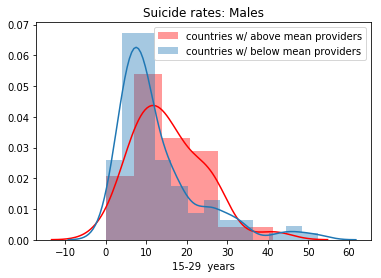

In [49]:
print("Number of countries in the above mean group:", len(df_suicide_rate_male_above))
print("Number of countries in the above mean group:", len(df_suicide_rate_male_below))

sns.distplot(df_suicide_rate_male_above["15-29  years"], color='red', label="countries w/ above mean providers")
sns.distplot(df_suicide_rate_male_below["15-29  years"], label="countries w/ below mean providers")
plt.title("Suicide rates: Males")
plt.legend()
plt.savefig("raw_dist_males")

### T TEST: 2 independent samples

 We again bootstrapped samples and plotted the sampling distributions by the same procedure as before. 

Similar to our previous results, we found that countries with more mental health resources also had more reported suicide, though the effect size is small.



With p=0.0, we can reject the Null Hypothesis. These populations are different.


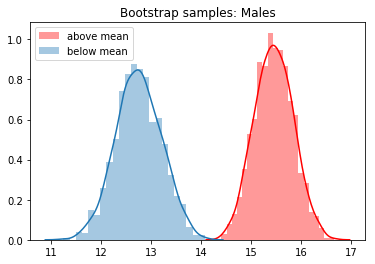

In [50]:
samp1=df_suicide_rate_male_above["15-29  years"]
samp2=df_suicide_rate_male_below["15-29  years"]
bootstrap_and_compare(samp1, samp2, num_bootstraps=1000, size_bootstraps=500)
plt.title("Bootstrap samples: Males")
plt.legend()
plt.savefig("bootstrap_dist_males")

In [51]:
effect_size = (mean(samp1) - mean(samp2)) / (sqrt((stdev(samp1) ** 2 + stdev(samp2) ** 2) / 2))

print("Effect size:", effect_size)

Effect size: 0.28373686568030676


## Females only?

* ### Alternative Hypothesis 3:

There is a difference in suicide rates for females in countries below and above the mean threshold of mental health professionals per 100,000 for people ages 15-29.

* ### Null Hypothesis: 

There is no difference.

Here are the raw distributions prior to our bootstrapping procedure.

Number of countries in the above mean group: 35
Number of countries in the above mean group: 114


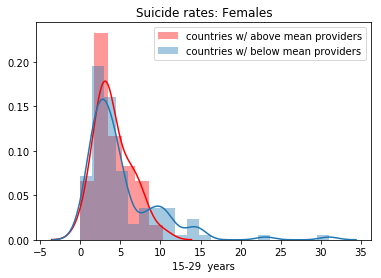

In [52]:
print("Number of countries in the above mean group:", len(df_suicide_rate_female_above))
print("Number of countries in the above mean group:", len(df_suicide_rate_female_below))

sns.distplot(df_suicide_rate_female_above["15-29  years"], color='red', label="countries w/ above mean providers")
sns.distplot(df_suicide_rate_female_below["15-29  years"], label="countries w/ below mean providers")
plt.title("Suicide rates: Females")
plt.legend()
plt.savefig("raw_dist_females")


### T TEST: 2 independent samples

This time the above mean population has lower suicide rates than the below mean population though the effect size is small.

With p=0.0, we can reject the Null Hypothesis. These populations are different.


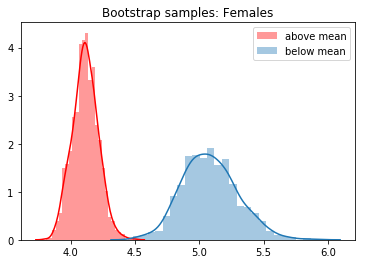

In [53]:
samp1=df_suicide_rate_female_above["15-29  years"]
samp2=df_suicide_rate_female_below["15-29  years"]
bootstrap_and_compare(samp1, samp2, num_bootstraps=1000, size_bootstraps=500)
plt.title("Bootstrap samples: Females")
plt.legend()
plt.savefig("bootstrap_dist_females")

In [54]:
effect_size = (mean(samp1) - mean(samp2)) / (sqrt((stdev(samp1) ** 2 + stdev(samp2) ** 2) / 2))

print("Effect size:", effect_size)

Effect size: -0.26564335647727033


# Conclusions

In this study, we learned that countries with high numbers of mental health providers per 100,000 had somewhat more reported suicides per 100,000 in 2016 for ages 15-29 than countries with low numbers of mental health providers. We caution readers that there are many possible explanations for this such as differences in reporting. See the readme for a more thorough treatment of this issue. 

We also learned that countries with more mental health providers available had fewer suicides for females than countries with fewer providers. Again, the effect size is small, but it does suggests that having more mental health resources available may be improving outcomes for females. More research is needed to confirm this.  